# Part 1 - Exploratory Data Analysis for Logins Data

### Importing Packages

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar

### Loading Data

In [3]:
# loading json file
with open('logins.json') as file:
    logins_json = json.load(file)

# Converting data inro Pandas DataFrame with login_time as a datetime index
logins_df = pd.DataFrame(logins_json)
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df = logins_df.set_index('login_time')

### Aggregating and Creating New Features

In [4]:
# Aggregation of loging counts based on 15 minute time intervals
logins_15 = pd.DataFrame(logins_df.resample('15min').size(), columns = ['Count']).sort_index().reset_index()

# Creating new features for analysis of time series
logins_15['Date'] = logins_15['login_time'].dt.date
logins_15['Year'] = logins_15['login_time'].dt.year
logins_15['Month'] = logins_15['login_time'].dt.month
logins_15['Day'] = logins_15['login_time'].dt.day
logins_15['Hour'] = logins_15['login_time'].dt.hour
logins_15['Week'] = logins_15['login_time'].dt.strftime('%W')
logins_15['Weekday'] = logins_15['login_time'].dt.dayofweek

### Data Quality

There are no missing values.

In [5]:
logins_15.isna().sum()

login_time    0
Count         0
Date          0
Year          0
Month         0
Day           0
Hour          0
Week          0
Weekday       0
dtype: int64

There are no duplicates

In [6]:
logins_15.duplicated().sum()

0

All time periods follow one another consecutively, with no gaps in between.

In [7]:
t = logins_15['login_time'].diff()
print(f'Minimal difference between periods - {min(t[1:])}')
print(f'Maximal difference between periods - {max(t[1:])}')

Minimal difference between periods - 0 days 00:15:00
Maximal difference between periods - 0 days 00:15:00


However, there are 407 fifteen-minute time periods without any logins. This does not indicate a problem or an error, but it might be worth paying some attention to.

In [36]:
# Finding period with 0 logings
gaps = logins_15[logins_15['Count'] == 0].groupby(['Week', 'Day', 'Hour'])['Count'].size().reset_index()

# Counting number of 0 periods per hour
gaps.sort_values(by = 'Count', ascending = False)

,Week,Day,Hour,Count
168,07,19,8,4
19,01,8,15,4
120,05,4,6,3
125,05,5,5,3
269,14,7,6,3
...,...,...,...,...
110,05,2,8,1
111,05,3,2,1
112,05,3,5,1
113,05,3,6,1


## Exploratory Data Analysis

### The Whole Available Period 

The visualization shows that logins exhibit some cycles (possibly weekly) and an increasing trend until around the 20th of March. The 7-days moving average illustrates this trend.

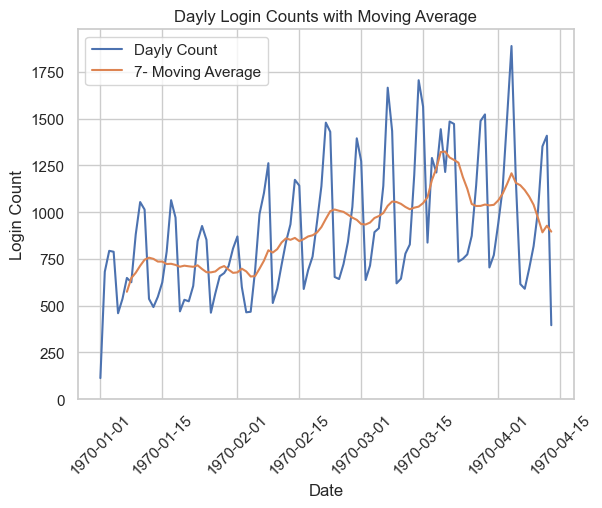

In [9]:
df_day = logins_15.groupby(['Date'])[['Count']].sum().reset_index()
df_day.loc[:, ['MA']] = df_day['Count'].rolling(window = 7).mean()

sns.set(style="whitegrid")
sns.lineplot(x = 'Date', y = 'Count', data = df_day, label='Dayly Count')
sns.lineplot(x = 'Date', y = 'MA', data = df_day, label='7- Moving Average')
plt.ylim(bottom = 0)
plt.title('Dayly Login Counts with Moving Average')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Login Count')
plt.legend()
plt.show()

### The Weekly Login Counts

The weekly login counts highlight the general trend even more clearly. We can see the growth of logins untill around 11th week.

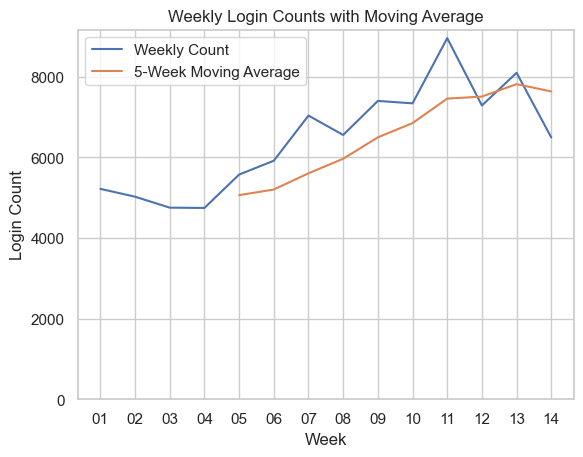

In [10]:
df_week = logins_15.groupby(['Week'])[['Count']].sum().reset_index()
df_week_filtered = df_week[(df_week['Week'] > min(df_week['Week'])) & ((df_week['Week'] < max(df_week['Week'])) )]
df_week_filtered.loc[:, ['MA']] = df_week_filtered['Count'].rolling(window = 5).mean()

sns.lineplot(x = 'Week', y = 'Count', data = df_week_filtered, label='Weekly Count')
sns.lineplot(x = 'Week', y = 'MA', data = df_week_filtered, label='5-Week Moving Average')
plt.ylim(bottom = 0)
plt.title('Weekly Login Counts with Moving Average')
plt.xlabel('Week')
plt.ylabel('Login Count')
plt.legend()
plt.show()

### Weekdays Login Counts

The Weekdays login counts confierms our earlier hypothesis - there is a clear interweek cycles. The lowers usage of the system according to the login counts is on Monday, it doubles on Saturday, decreases a little bit on Sunday and drops on Monday. 

The weekday login counts confirm our earlier hypothesis — there are clear interweek cycles. The lowest system usage, based on login counts, occurs on Monday. It doubles on Saturday, decreases slightly on Sunday, and drops again on Monday.

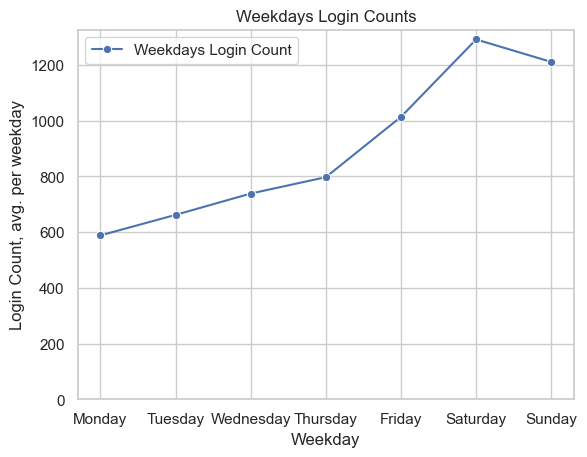

In [11]:
df_weekday = logins_15.groupby(['Week', 'Weekday'])['Count'].sum().reset_index()
df_weekday = df_weekday.groupby(['Weekday'])['Count'].mean().reset_index()

sns.lineplot(x = 'Weekday', y = 'Count', data = df_weekday, marker = 'o', label='Weekdays Login Count')
plt.ylim(bottom = 0)
plt.title('Weekdays Login Counts')
plt.xlabel('Weekday')
plt.xticks(range(7), labels = list(calendar.day_name))
plt.ylabel('Login Count, avg. per weekday')
plt.legend()
plt.show()

### Intraday Trends

According to the visualization, there are two peaks in logins — one at night and another at 11 a.m.

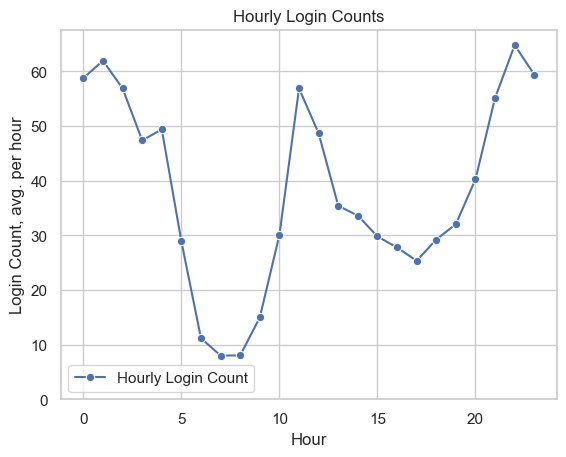

In [12]:
df_hour = logins_15.groupby(['Date', 'Hour'])['Count'].sum().reset_index()
df_hour = df_hour.groupby(['Hour'])['Count'].mean().reset_index()

sns.lineplot(x = 'Hour', y = 'Count', data = df_hour, marker = 'o', label='Hourly Login Count')
plt.ylim(bottom = 0)
plt.title('Hourly Login Counts')
plt.xlabel('Hour')
plt.ylabel('Login Count, avg. per hour')
plt.legend()
plt.show()

The heatmap provides a two-dimensional view of intraday dynamics — by hours and weekdays — offering a clearer picture of service usage. The service usage pattern remains stable throughout weekdays, but changes begin to emerge on Friday evening. Login counts start increasing at 9 p.m. on Friday, peaking at 4 a.m. A similar pattern is observed during the night from Saturday to Sunday.

The lowest service usage occurs between 3 a.m. and 9 a.m. on weekdays. This low-usage period is shorter and shifts three hours later on Saturday and Sunday.

Service usage is higher than average around midday on weekdays, but this pattern is less distinct on weekends.

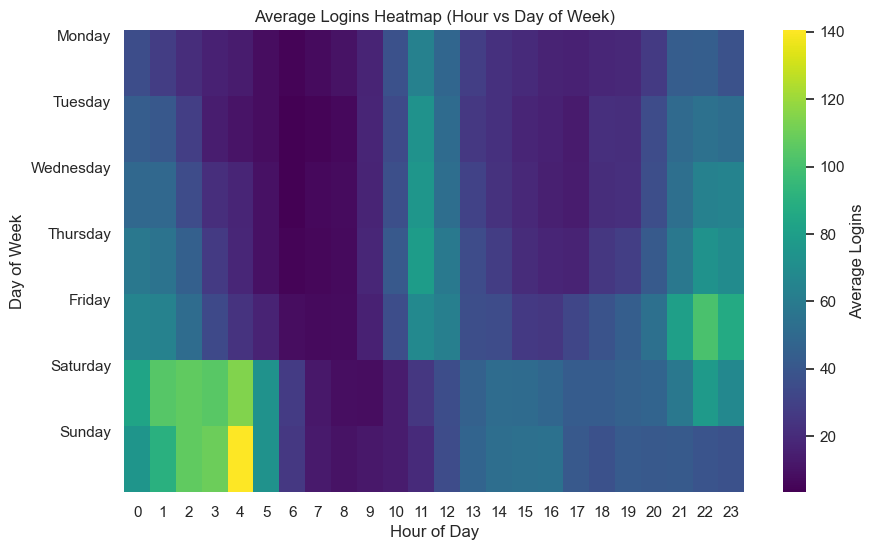

In [13]:
df_hour = logins_15.groupby(['Week', 'Weekday', 'Hour'])['Count'].sum().reset_index()
heatmap_data_unstack = df_hour.groupby(['Weekday', 'Hour'])['Count'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_unstack, cmap='viridis', annot=False, cbar_kws={'label': 'Average Logins'})
plt.title('Average Logins Heatmap (Hour vs Day of Week)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(range(7), list(calendar.day_name), rotation = 0, va = 'top')
plt.show()

## Conclusions:

1.	__Data Completeness:__ There are no missing values, and all time periods follow consecutively without gaps. However, 407 fifteen-minute time periods have no logins, which may warrant further investigation.  
2.	__Weekly Patterns:__ Logins show clear weekly cycles with the lowest usage on Mondays, a significant increase on Saturdays, and slightly reduced activity on Sundays before dropping again on Mondays.  
3.	__Growth Trends:__ Login activity exhibits an increasing trend until mid-March, as highlighted by both the raw data and the 7-day moving average. Weekly login counts further confirm this growth, which peaks around the 11th week.  
4.	__Intraday Dynamics:__ Two peaks in logins occur — one at night and another around 11 a.m. Service usage is consistently low between 3 a.m. and 9 a.m. on weekdays, with this low-usage period shifting and shortening on weekends.  
5.	__Weekend Behavior:__ Service usage changes on Friday evenings, with login counts rising from 9 p.m. and peaking at 4 a.m. Similar patterns are observed during the nights from Saturday to Sunday.  
6.	__Weekday vs. Weekend Usage:__ Service usage is higher than average around midday on weekdays, but this pattern becomes less observable on weekends.  

# Part 2 - Experiment and Metrics Design

### 1. Key Measure of Success:

I would choose two metrics to measure the success of the experiment in encouraging driver partners to serve both cities:  
1.	The share of driver partners available in both cities, as an earlier leading indicator.  
2.	The financial results (for example, Gross Margin (GM) or Operational Income Before Depreciation and Amortization (OIBDA)), which encompass the increase in revenue from driver partners available in both cities, minus the reimbursement of all toll costs.  

The most important measure, in my opinion, is the second one — financial outcome — because the initiative could be very popular among driver partners and perform well in terms of the first metric (the share of driver partners participating in the initiative), but still result in a negative financial outcome. (We are not provided with information about the relationship between revenue and reimbursement of toll costs. If revenue is inherently higher than reimbursement, then we could rely solely on the share of driver partners available in both cities.)  


### 2. Experiment Design and Interpretation of the Results:  

a) Experiment Implementation (Brief):  
	
1.	First, it is necessary to discuss the experiment and its implementation with the Ultimate managers of city operations to define a clear goal, agree on key metrics and their interpretation, gather useful information about the experiment’s subject—driver partners (e.g., are there any strata among partners?), and address implementation issues, such as the random split of driver partners into participants and non-participants, along with any other valuable insights.  

2.	Develop and approve the methodology with key stakeholders for splitting participants and calculating key metrics. Questions to address include: What algorithm will be used for the split? How will we calculate the key metrics if they are not already available in the system? How long will the experiment last? Additionally, the significance level (p-value) should be agreed upon prior to the experiment.  

3.	Evaluate the IT systems required for the experiment: How can we implement the split algorithm? Where (in which system and using which interface) will we measure the metrics? Do we need software development to implement the experiment, or can we use a combination of ERP systems and hands-on tools like Excel, standalone databases, and analytical tools?  

4.	Develop and implement all required changes, ensuring proper testing before running the experiment.  

5.	Collect the data and calculate the metrics separatly for each group (particapting in the experiment, and those not participating).  


b) Analysis After the Experiment:

After completing the experiment, I will perform a t-test for statistical significance on the key metrics (the share of driver partners available in both cities and/or financial results) between the two groups of driver partners: those participating in the experiment and those not participating. The null hypothesis is that there is no difference between the two groups.

c) Interpretation of Results:

Following the t-test, we will evaluate the p-value. If the p-value is higher than the agreed significance level, we cannot reject the null hypothesis (i.e., there is no difference between the control group and the experimental group), meaning the experiment failed. If the p-value is lower than the significance level, we can reject the null hypothesis, indicating the experiment was successful.

# Part 3 - Predictive Modeling

## 1. Data Wrangling and EDA

In [ ]:
import json
import pandas as pd
import numpy as np

In [ ]:
# Loading the data from json file into Pandas DataFrame
with open('ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)

ultimate_df = pd.DataFrame(data)

# Preview the data and data structure
with pd.option_context('display.width', 200):
    print(ultimate_df.head())
    print(ultimate_df.info())

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver
0  King's Landing                       4  2014-01-25                   4.7       1.10     2014-06-17   iPhone       15.4                 True         46.2      3.67                   5.0
1         Astapor                       0  2014-01-29                   5.0       1.00     2014-05-05  Android        0.0                False         50.0      8.26                   5.0
2         Astapor                       3  2014-01-06                   4.3       1.00     2014-01-07   iPhone        0.0                False        100.0      0.77                   5.0
3  King's Landing                       9  2014-01-10                   4.6       1.14     2014-06-29   iPhone       20.0                 True         80.0      2.36                   4.9
4      Winterfell                      14  2014-01-27       

In [ ]:
# Converting object type fielda to datetime
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

# Calculating the date of the last recorded trip and saving it in last_date
print('The date of the last recorded trip: {:%Y-%m-%d}'.format(last_date := max(ultimate_df['last_trip_date'])))

The date of the last recorded trip: 2014-07-01


### Clearing and imputing the data

In [ ]:
ultimate_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [ ]:
ultimate_df.loc[ultimate_df.duplicated(keep = False)].sort_values(by = ['signup_date', 'last_trip_date', 'avg_dist'])

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
26709,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
5958,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
14990,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0


In [ ]:
ultimate_df = ultimate_df.drop_duplicates()

In [ ]:
ultimate_df.loc[ultimate_df['phone'].isna(), 'phone'] = 'other'

In [ ]:
ultimate_df[['avg_rating_of_driver', 'avg_rating_by_driver']].describe()

,avg_rating_of_driver,avg_rating_by_driver
count,41873.000000,49791.000000
mean,4.601512,4.778123
std,0.617360,0.446679
min,1.000000,1.000000
25%,4.300000,4.700000
50%,4.900000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


It would be incorrect ot impute missed ratings by 0 values, so I will imptute by median values

In [ ]:
ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].median(skipna = True))
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].median(skipna = True))

In [ ]:
ultimate_df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [ ]:
ultimate_df['pnone_code'] = ultimate_df['phone'].astype('category').cat.codes
ultimate_df['city_code'] = ultimate_df['city'].astype('category').cat.codes

### Creating the new feature - Retained (boolean)

In [ ]:
ultimate_df['retained'] = [True if int(x) < 30 else False for x in (pd.to_datetime(last_date) - ultimate_df['last_trip_date']).dt.days]
with pd.option_context('display.width', 300):
    print(ultimate_df.head(15))
print('The fraction of retained users is {:.2%}'.format(ultimate_df['retained'].mean()))

              city  trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  pnone_code  city_code  retained
0   King's Landing                       4  2014-01-25                   4.7       1.10     2014-06-17   iPhone       15.4                 True         46.2      3.67                   5.0           1          1      True
1          Astapor                       0  2014-01-29                   5.0       1.00     2014-05-05  Android        0.0                False         50.0      8.26                   5.0           0          0     False
2          Astapor                       3  2014-01-06                   4.3       1.00     2014-01-07   iPhone        0.0                False        100.0      0.77                   5.0           1          0     False
3   King's Landing                       9  2014-01-10                   4.6       1.14     2014-06-29   iPhone 

### Exploratory Data Analysis

In [ ]:
heatmap = ultimate_df.select_dtypes(include = ['number', 'bool']).corr()

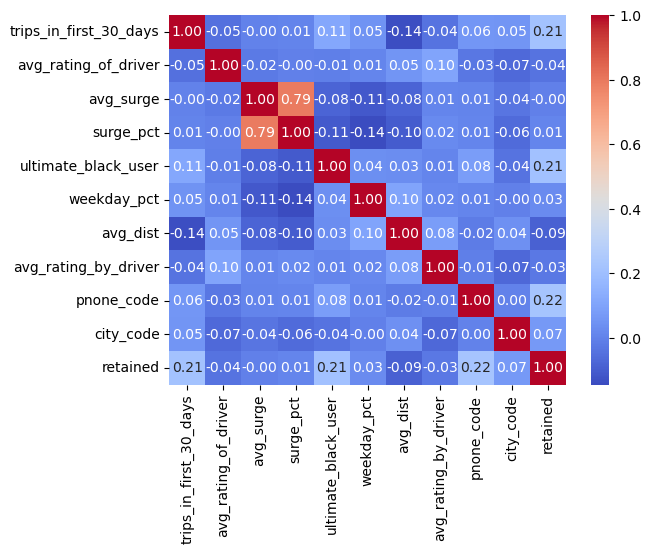

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(heatmap, annot = True, fmt='.2f', cmap='coolwarm')
plt.show()

We can see some correlation between retention (retained) and the number of trips in the first 30 days (0.21), whether the user has an Ultimate Black status or not (0.21), and the type of phone (0.22). All other factors have a correlation close to 0.

I visualized some of these relationships between retention and these three factors below. I also visualized the relationship between retention and the share of trips with a surge multiplier.

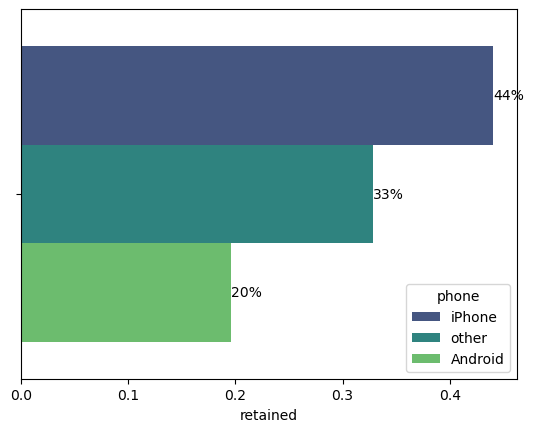

In [ ]:
ax = sns.barplot(data = pd.pivot_table(data = ultimate_df, 
                                  index = 'phone', 
                                  columns = None, 
                                  values = 'retained', 
                                  aggfunc = 'mean').sort_values(by = 'retained', ascending = False), 
            x ='retained', hue = 'phone', 
            orient='h', palette='viridis')
for cntr in ax.containers: 
    labels = [f"{v.get_width() * 100:.0f}%" for v in cntr]
    ax.bar_label(cntr, labels = labels, label_type='edge')
plt.show()

The iPhone users have the highest retention rate, the Android users - the lowest

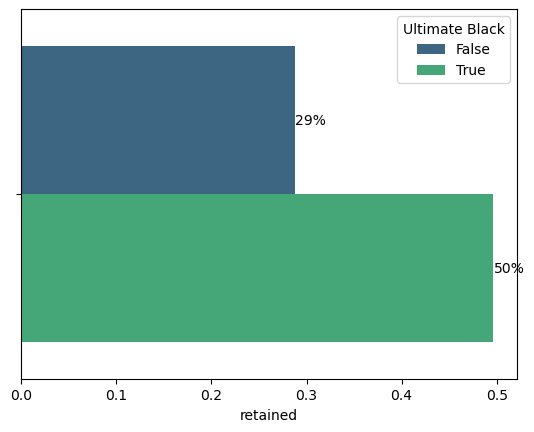

In [ ]:
df = ultimate_df
df['ultimate_black_user'] = df['ultimate_black_user'].astype('category')
pt = pd.pivot_table(data = df, 
                    index = 'ultimate_black_user', 
                    columns = None, 
                    values = 'retained', 
                    aggfunc = 'mean', observed = False).sort_values(by = 'retained', ascending = True)

ax = sns.barplot(data = pt, 
            x ='retained', hue = 'ultimate_black_user', 
            orient='h', palette='viridis')
for cntr in ax.containers: 
    labels = [f"{v.get_width() * 100:.0f}%" for v in cntr]
    ax.bar_label(cntr, labels = labels, label_type='edge')
plt.legend(title = 'Ultimate Black')
plt.show()

The users with Ultimate Black status are more loyal then other users.

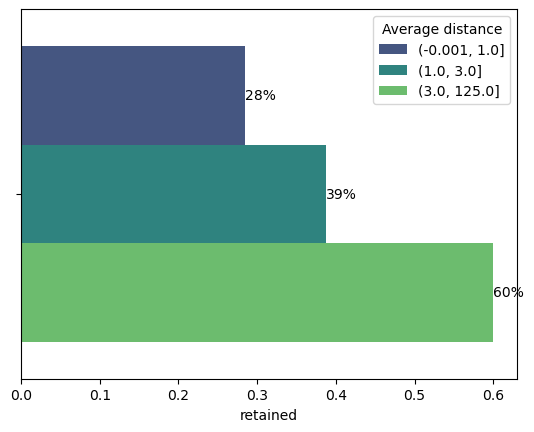

In [ ]:
ultimate_df['trips_in_first_30_days_cat'] = pd.qcut(ultimate_df['trips_in_first_30_days'], q = 4, duplicates = 'drop')
pt = pd.pivot_table(data = ultimate_df, 
                    index = 'trips_in_first_30_days_cat', 
                    columns = None, 
                    values = 'retained', 
                    aggfunc = 'mean', observed = False)

ax = sns.barplot(data = pt, 
                 x = 'retained', hue = 'trips_in_first_30_days_cat', 
                 orient='h', palette='viridis')
for cntr in ax.containers: 
    labels = [f"{v.get_width() * 100:.0f}%" for v in cntr]
    ax.bar_label(cntr, labels = labels, label_type='edge')
plt.legend(title = 'Average distance')
plt.show()

The more users traveled the first month, the more loyal they are

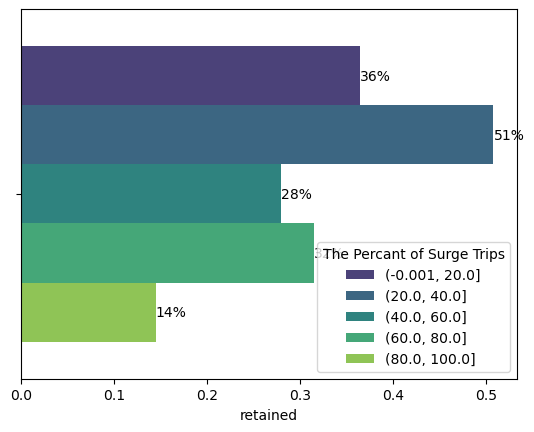

In [ ]:
ultimate_df['surge_pct_cat'] = pd.cut(ultimate_df['surge_pct'], bins = [0, 20, 40, 60, 80, 100], include_lowest = True) 
pt = pd.pivot_table(data = ultimate_df, 
                    index = 'surge_pct_cat', 
                    columns = None, 
                    values = 'retained', 
                    aggfunc = 'mean', observed = False)

ax = sns.barplot(data = pt, 
                 x = 'retained', hue = 'surge_pct_cat', 
                 orient='h', palette='viridis')
for cntr in ax.containers: 
    labels = [f"{v.get_width() * 100:.0f}%" for v in cntr]
    ax.bar_label(cntr, labels = labels, label_type='edge')
plt.legend(title = 'The Percant of Surge Trips')
plt.show()

There is no observable clear relation between loyalty (retention) and share of trips with surge multiplier

## 2. Predictive Model

In [ ]:
# Loading packages 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Short discription of features for graphs
feature_names = [
    'Signup date', 
    'Trips in the first 30 days',
    'Average distance in the first 30 days',
    'Average rider\'s rating',
    'Average rating for drivers',
    'Share of trips with surge multiplier',
    'Average surge multiplier',
    'Ulrimate Black (in the first 30 days)',
    'Share of trips during weekday',
    'City King\'s Landing',
    'City Winterfell',
    'iPhone',
    'Other']

# Function printing model performance metrics
def print_results(y_test, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

def plot_feature_importances(num_features, importances, order):
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(num_features), importances[order], align="center")
    plt.xticks(range(num_features), [feature_names[i] for i in order], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

In [ ]:
# One Hot Encoding categorical variables
X = pd.get_dummies(ultimate_df, columns = ['city', 'phone'], drop_first = True)

# Converting dates to integers
X['signup_date'] = X['signup_date'].astype('int')
X['last_trip_date'] = X['last_trip_date'].astype('int')

# Reordering the DataFrame and removing redundant columns:
# - 'city_code' and 'phone_code': These columns contain duplicate information already represented in the respective OneHotEncoded 
#   columns.
# - 'last_trip_date': This column is encoded in the target variable ('retained').

new_order = [
    'signup_date', 
    'trips_in_first_30_days',
    'avg_dist',
    'avg_rating_of_driver',
    'avg_rating_by_driver',
    'surge_pct',
    'avg_surge',
    'ultimate_black_user',
    'weekday_pct',
    'city_King\'s Landing',
    'city_Winterfell',
    'phone_iPhone',
    'phone_other',
    'retained']
X = X.reindex(columns = new_order)

# Splitting data onto features and target variable
y = X.iloc[:, -1]
X = X.iloc[:, :-1]

In [ ]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1812)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Choosing the Model

We need to predict the class of the rider — Active or Churn (in our dataset, this relates to the ‘retained’ field with True or False values). This is a classification task. There are several models available, starting from the simplest Logistic Regression and ending with Neural Networks. The dataset we have is not very large, so the simplest models will be able to solve the task in a reasonable time. Also, we need to translate and explain the insights gained from the model to the team at Ultimate. In this case, the results of the model should be easily interpretable. This makes it almost impossible to use Neural Networks. Among the other models, I am going to use Logistic Regression first to get a sense of the data and establish a benchmark for accuracy. Finally, I am going to use a Random Forest Classification model due to its simplicity and because it is easier to interpret than Gradient Boosted Decision Trees (which could also perform well on this type of task but are more difficult to interpret).

#### Logistic Regression

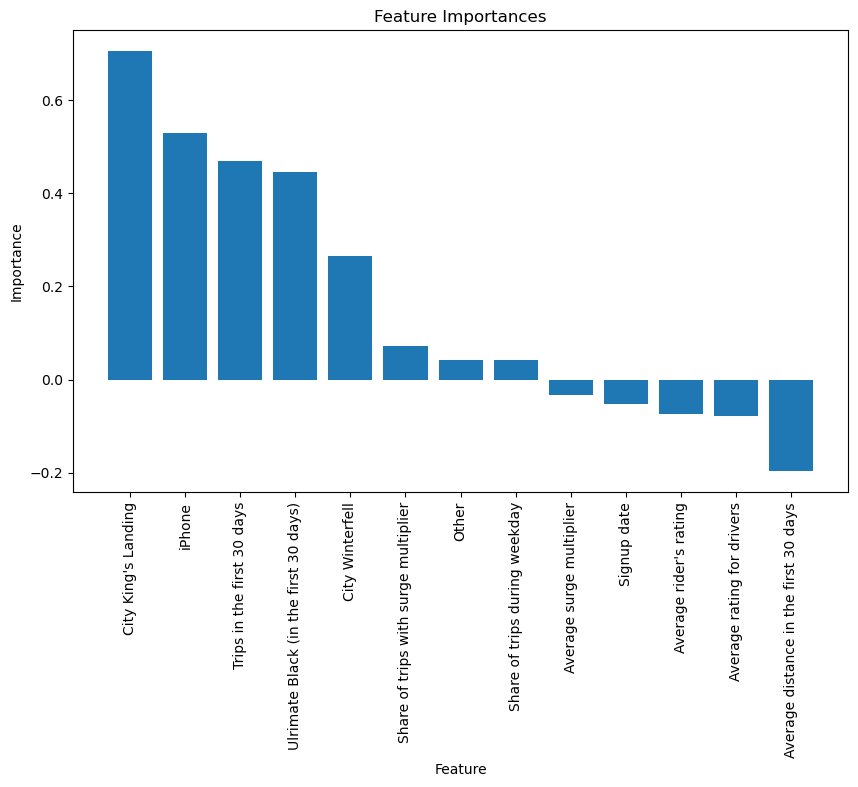

In [ ]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
importances_LR = model_LR.coef_[0]

# Getting indices for sorted feature importances in descending order
indices_LR = np.argsort(importances_LR)[::-1]
plot_feature_importances(X.shape[1], importances_LR, indices_LR)

In [ ]:
y_pred = model_LR.predict(X_test)
print_results(y_test, y_pred)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.86      0.80      6318
        True       0.67      0.51      0.58      3681

    accuracy                           0.73      9999
   macro avg       0.71      0.68      0.69      9999
weighted avg       0.72      0.73      0.72      9999

Confusion Matrix:
[[5405  913]
 [1819 1862]]


We can see that the Logistic Regression model correctly predicted churn in 75% of all users predicted as churn by the model (precision of the False value is 0.75), and of all really churned users, the model correctly predicted 86% (recall for the False value is 0.86). The harmonic mean of precision and recall is 80% (F1-score for the False value), which is quite good performance for the base model. The business should choose which metric is better for them - precision or recall. The main consideration in this case is what is more critical for the business - not missing any user who can churn (recall is better) or not wasting company resources on users who actually would not churn (precision metric is better in this case).

#### Random Forest Classifier

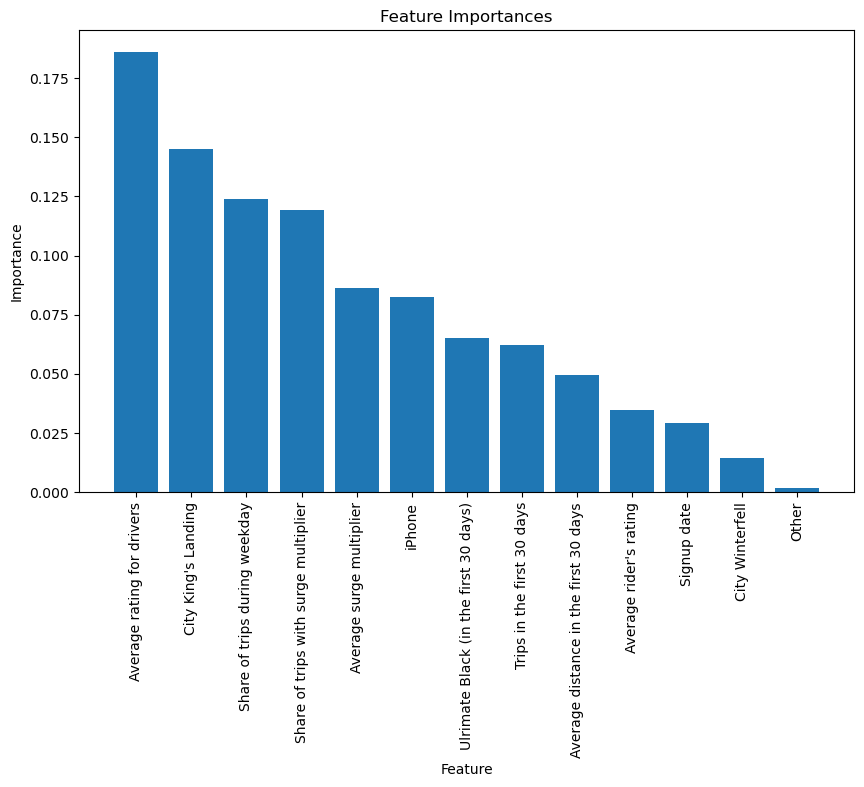

In [ ]:
# Setting params fro Grid Search Cross-Validation
param = {'max_depth': [3, 5, 10, 25, 50], 
         'n_estimators': [10, 25, 50, 100],
         'random_state': [1812]}

RFClassifier = RandomForestClassifier()
cv_model = GridSearchCV(RFClassifier, param_grid = param, cv = 5)
cv_model.fit(X_train, y_train)

# Feature importance
importances_RFC = cv_model.best_estimator_.feature_importances_

# Getting indices for sorted feature importances in descending order
indices_RFC = np.argsort(importances_RFC)[::-1]

plot_feature_importances(X.shape[1], importances_RFC, indices_RFC)

In [ ]:
# Make predictions
y_pred = cv_model.best_estimator_.predict(X_test)
print_results(y_test, y_pred)

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.87      0.84      6318
        True       0.75      0.64      0.69      3681

    accuracy                           0.79      9999
   macro avg       0.78      0.76      0.76      9999
weighted avg       0.78      0.79      0.78      9999

Confusion Matrix:
[[5513  805]
 [1324 2357]]


We can see that the Random Forest Classification model correctly predicted churn in 81% of all users predicted as churn by the model (precision of the False value is 0.81), which is better than Logistic Regression precision of 75%. Of all really churned users, the model correctly predicted 87% (recall for the False value is 0.87),  which is quite the same as the recall of Logistic Regression. The harmonic mean of precision and recall is 84% (F1-score for the False value), which is quite good performance for the base model and better than Logistic Regresssion model results. 

The business should choose which metric is better for them - precision or recall. The main consideration in this case is what is more critical for the business - not missing any user who can churn (recall is better) or not wasting company resources on users who actually would not churn (precision metric is better in this case).

### Comparison of two model's performance

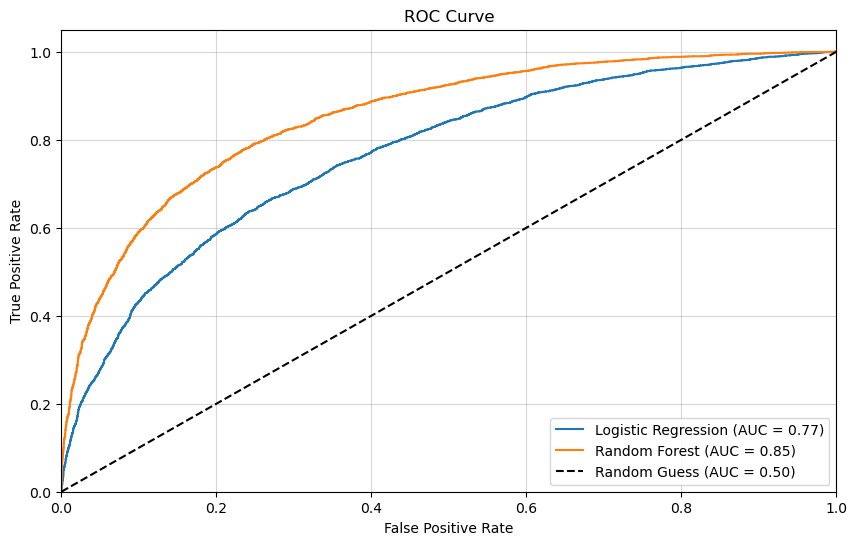

In [ ]:
from sklearn.metrics import roc_curve, auc


y_pred_proba_LR = model_LR.predict_proba(X_test)[:, 1]
y_pred_proba_RFC = cv_model.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_LR, tpr_LR, _ = roc_curve(y_test, y_pred_proba_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

# Compute ROC curve and AUC for Random Forest
fpr_RFC, tpr_RFC, _ = roc_curve(y_test, y_pred_proba_RFC)
roc_auc_RFC = auc(fpr_RFC, tpr_RFC)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_LR, tpr_LR, label=f"Logistic Regression (AUC = {roc_auc_LR:.2f})")
plt.plot(fpr_RFC, tpr_RFC, label=f"Random Forest (AUC = {roc_auc_RFC:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

According to ROC Curve the Random Forest Classification model performs better than Logistic Regression

## 3. Who to leverage the results:

Taking into account the importance of features for retention, I would recommend the Ultimate team the following next steps:  
1.	Pay special attention to the drivers’ quality of service because this factor is the most important. It might be worth researching the drivers with the lowest and highest ratings: what do the worst drivers do wrong, and what do the best drivers do well? Do users value this? Maybe some training and/or changes in motivation are needed.  
2.	We can also observe that the city of user registration can influence retention: particularly, user retention is highly influenced by registration in the city of King’s Landing. What differentiates this city from others to such an extent? Which subfactors influence user retention in this city?  
3.	It is necessary to research the requirements for two categories of riders: those who have trips mostly during weekdays and those who trip mostly during weekends. Which of them are more loyal? Why? Are there opportunities to improve retention for the other category?